In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from Bio import SeqIO
from Bio import Align

import json
import numpy as np
from functools import reduce
from utils import load_patients, load_viruses, compute_virus_alignment_score

# Example with `gap_score`

In [3]:
aligner = Align.PairwiseAligner()
aligner.open_gap_score = -1
aligner.extend_gap_score = -1
aligner.target_end_gap_score = 0.0
aligner.query_end_gap_score = 0.0

alignments = aligner.align("TATCC", "AC")
for alignment in sorted(alignments):
    print("Score = %.1f:" % alignment.score)
    print(alignment)

alignments.alignment.__dict__

Score = 1.0:
TATCC
-|-|-
-A-C-

Score = 1.0:
TATCC
-|.--
-AC--

Score = 1.0:
TATCC
--.|-
--AC-

Score = 1.0:
TATCC
---.|
---AC



{'target': 'TATCC',
 'query': 'AC',
 'score': 1.0,
 'path': ((0, 0), (3, 0), (5, 2))}

# Loading data

In [4]:
viruses_full = load_viruses()
patients_identity_full, patients_entries_full = load_patients()
print(patients_entries_full.shape)
print(patients_identity_full.shape)

viral.3.2.genomic.fna	... Done.
viral.2.3.genomic.fna	... Done.
viral.3.1.genomic.fna	... Done.
viral.2.1.genomic.fna	... Done.
viral.1.1.genomic.fna	... Done.
viral.2.4.genomic.fna	... Done.
viral.2.2.genomic.fna	... Done.
PT8-S2.fastq	... Done.
PT9-S1.fastq	... Done.
PT8-S1.fastq	... Done.
PT7-S1.fastq	... Done.
PT2-S1_1.fastq	... Done.
(310541,)
(310541,)


In [5]:
with open('popular_virus_names.json', 'r') as f:
    popular_viruses_keys = json.load(f)

In [19]:
n_viruses = 50
n_entries = 100

np.random.seed(42)

viruses = {k:viruses_full[k] for k in popular_viruses_keys[:n_viruses]}

random_idx = np.arange(patients_entries_full.shape[0])
np.random.shuffle(random_idx)
random_idx = random_idx[:n_entries]

patients_entries = patients_entries_full[random_idx]
patients_identity = patients_identity_full[random_idx]

In [20]:
from multiprocessing import Pool

aligner = Align.PairwiseAligner()
aligner.open_gap_score = -1
aligner.extend_gap_score = -1
aligner.target_end_gap_score = 0.0
aligner.query_end_gap_score = 0.0


def comp_al_score(patients_vdna):
    patients_entries, virus_dna = patients_vdna
    return compute_virus_alignment_score(patients_entries, virus_dna, aligner)


tuples_to_process = [(patients_entries, v_dna) for v_dna in viruses.values()]

with Pool(8) as p:
    alignements_scors_list = p.map(
        comp_al_score, 
        tuples_to_process
    )

result = np.array(alignements_scors_list).T

In [21]:
result

array([[ 70.,  66.,  68., ...,  65.,  66.,  74.],
       [ 70.,  71.,  71., ...,  74.,  76.,  75.],
       [105.,  65.,  68., ...,  64.,  65.,  66.],
       ...,
       [ 48.,  47.,  45., ...,  47.,  47.,  44.],
       [ 72.,  71.,  74., ...,  73.,  72.,  71.],
       [ 72.,  71.,  73., ...,  79.,  73.,  72.]])

In [30]:
result /= result.max(axis=0)

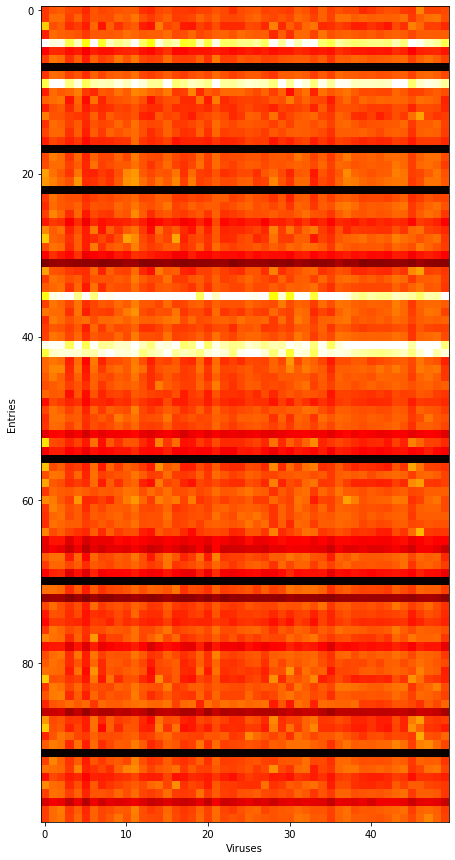

In [31]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(15, 15))
plt.xlabel('Viruses')
plt.ylabel('Entries')
plt.imshow(result, cmap='hot', interpolation='nearest');